In [5]:
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt
import emcee
from scipy.integrate import quad
from scipy import interpolate
from chain_analysis import contour_plot, gelman_rubin
import time
import pymultinest
from collections import OrderedDict
%matplotlib nbagg
%load_ext autoreload

In [6]:
plt.rcParams['nbagg.transparent'] = False
plt.rcParams['figure.facecolor'] = 'w'

In [7]:
def make_data(N, m=2, c=1, y_err=0.1, x_err=0, y_err_actual=0.5, x_err_actual=0, x_mu=0, x_sig=0):
    """
    Function to create straight line data.
    
    Parameters
    ----------
    N : int
        Number of data points
    m : float
        Gradient
    c : float
        Intercept
    y_err : float
        The errorbar on y (not necessarily the same as the scatter)
    x_err : float
        The errorbar on x (not necessarily the same as the scatter)
    y_err_actual : float
        Standard deviation to scatter the y values by
    x_err_actual : float
        Standard deviation to scatter the x values by
    x_mu : float
        Mean of the Gaussian prior to be used in the drawing of the x values
    x_sig : float
        Standard deviation of the Gaussian prior to be used in the drawing of the x values. Set to zero for uniform.
    
    """
    
    if x_sig == 0:
        x = np.random.uniform(0, 1.0, N)
    else:
        x = np.random.randn(N)*x_sig + x_mu
    y = m*x + c + np.random.randn(N)*y_err_actual
    x += np.random.randn(N)*x_err_actual
    return np.column_stack((x, y, [y_err]*N, [x_err]*N))

In [34]:
class FitData:
    
    
    def __init__(self, dat, model='std', prior_choice='uniform', bounds=[]):
        """
        Class to encapsulate multinest fitting
        
        Parameters
        ----------
        dat : np.array
            Dataset with first column x, second y, third y_err, fourth x_err
        model : str
            Which likelihood function to use 'std' or 'zbeams'
        prior_choice : str
            Which prior to assume for the x values 'uniform' or 'gaussian'
        bounds : collections.OrderedDict, optional
            Dictionary of uniform bounds to give to Multinest for each parameter
        """

        if len(bounds) == 0:
            self.bounds = OrderedDict([
                    ('m', [1, 3]),
                    ('c', [0, 2]),
                    ('x', [0, 1]),
                    ('x_mu', [0, 1]),
                    ('x_sig', [0.01, 3.0]),
                ])
        else:
            self.bounds = bounds

        self.dat = dat
        self.prior_choice = prior_choice
        
        if model == 'std':
            self.lnprob = self.lnprob_std
            self.ndim = 2
        elif self.prior_choice == 'uniform':
            self.lnprob = self.lnprob_zbeams
            self.ndim = 2 + len(dat)
        else:
            self.lnprob = self.lnprob_zbeams
            self.ndim = 4 + len(dat)
            
        self.norm_y = np.sum(np.log(1/np.sqrt(np.pi*dat[:,2]**2)))
        self.norm_x = np.sum(np.log(1/np.sqrt(np.pi*dat[:,3]**2)))


    def lnprob_std(self, cube, ndim, nparams):
        """
        Log likelihood for multinest

        Parameters
        ----------
        cube : array-like
            Input parameter cube
        ndim : int
            Number of dimensions
        nparams : int
            Number of parameters actually varying

        Returns
        -------
        float
            Log likelihood
        """
        
        dat = self.dat 
        p = cube
        
        m, c = p[:2]
        y_fit = m*dat[:,0] + c

        chi2 = np.sum(((dat[:,1]-y_fit)/dat[:,2])**2)
        return self.norm_y - 0.5*chi2

    
    def lnprob_zbeams(self, cube, ndim, nparams):
        """
        Log likelihood for multinest

        Parameters
        ----------
        cube : array-like
            Input parameter cube
        ndim : int
            Number of dimensions
        nparams : int
            Number of parameters actually varying

        Returns
        -------
        float
            Log likelihood
        """
            
        dat = self.dat 

        p = np.zeros(ndim)
        for i in range(ndim):
            p[i] = cube[i]
            
        if self.prior_choice == 'uniform':
            m, c = p[:2]
            x_fit = p[2:]
        else:
            m, c, x_mu, x_sig = p[:4]
            x_fit = p[4:]

        y_fit = m*x_fit + c
        
        chi2_y = np.sum(((dat[:,1]-y_fit)/dat[:,2])**2)
        chi2_x = np.sum(((dat[:,0]-x_fit)/dat[:,3])**2)
        
        
        
        loglike = self.norm_x + self.norm_y -0.5*(chi2_y + chi2_x)

        if self.prior_choice == 'uniform':
            return loglike
        else:
            pri = len(x_fit)*np.log(1/np.sqrt(2*np.pi*x_sig**2))-0.5*np.sum(((x_fit - x_mu)/x_sig)**2)
            return pri + loglike
        
        

    def prior(self, cube, ndim, nparams):
        """
        Prior for multinest

        Parameters
        ----------
        cube : array-like
            Input parameter cube
        ndim : int
            Number of dimensions
        nparams : int
            Number of parameters actually varying

        Returns
        -------
        array
            Transformed parameter cube

        """
        keys = list(self.bounds.keys())
        
        if self.prior_choice == 'uniform':
            params = ['m', 'c']
        else:
            params = ['m', 'c', 'x_mu', 'x_sig']
        
        for i in range(len(params)):
            lower = self.bounds[params[i]][0]
            upper = self.bounds[params[i]][1]
            cube[i] = cube[i]*(upper-lower)+lower
        if ndim>2:
            for i in range(len(params), ndim):
                lower = self.bounds['x'][0]
                upper = self.bounds['x'][1]
                cube[i] = cube[i]*(upper-lower)+lower
        return cube



    def fit(self, chain_name='chain-', n_live_points=500, multimodal=True):
        """
        Actually do the inference
        
        Parameters
        ----------
        chain_name : str
            Root name for chain storage (multinest makes multiple files so this should be something like 'chain-')
        n_live_points : int
            Number of live points for nested sampling. Minimum should be 25*ndim
        multimodal : bool
            Allow multimodal mode in multinest
        """

        t1 = time.time()
        
        pymultinest.run(self.lnprob, self.prior, self.ndim, importance_nested_sampling = True, init_MPI = False,
                        resume = False, verbose = False, sampling_efficiency = 'parameter', 
                        n_live_points = n_live_points, outputfiles_basename = chain_name, multimodal = multimodal)
        print('Time taken', time.time()-t1)

## Testing with a straight line

In [43]:
m = 2
c = 1
x_err = 0.01
y_err = 0.005

<IPython.core.display.Javascript object>


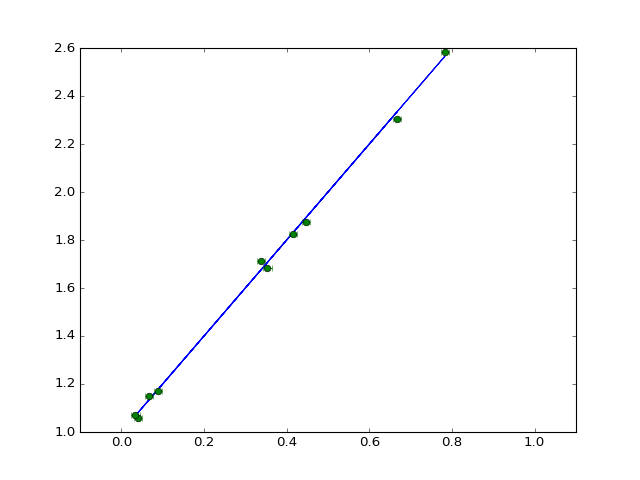

(-0.1, 1.1)

In [44]:
dat = make_data(10, m=m, c=c, y_err_actual=y_err, x_err_actual = x_err, y_err=y_err, x_err=x_err)
plt.figure()
plt.plot(dat[:,0], m*dat[:,0]+c)
plt.errorbar(dat[:,0], dat[:,1], linestyle='none', yerr=dat[:,2], xerr=dat[:,3], marker='o')

plt.xlim([-0.1, 1.1])

## Uniform Prior

In [45]:
fd = FitData(dat, model='std')

fd.fit(chain_name='chain_std_-')

Time taken 1.5814523696899414


In [46]:
fd = FitData(dat, model='zbeams')

fd.fit(chain_name='chain_zbeams_-')

Time taken 58.51054072380066


In [47]:
chain_std = np.loadtxt('chain_std-post_equal_weights.dat')
chain_zbeams = np.loadtxt('chain_zbeams-post_equal_weights.dat')


<IPython.core.display.Javascript object>


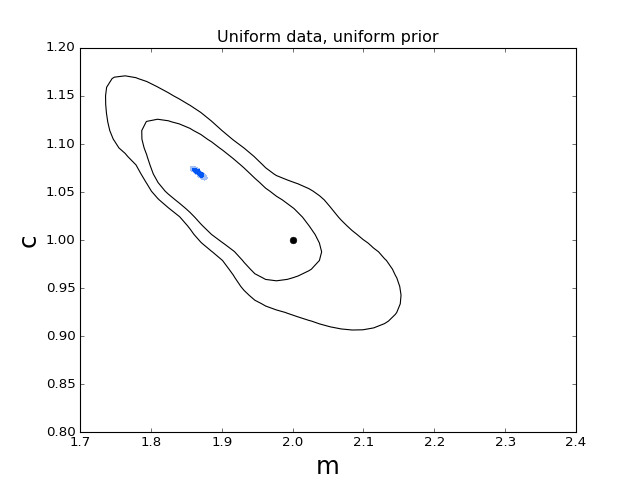

In [64]:
plt.figure()
smth = 2.5e3
contour_plot.contour(chain_std, [0,1], smooth=smth, labels=['m', 'c'])
contour_plot.contour(chain_zbeams, [0,1], smooth=smth*3, line=True, col='k')
plt.plot(m, c, 'ok')
plt.xlim([1.7, 2.4])
plt.ylim(0.8, 1.2)
plt.title('Uniform data, uniform prior')

### Uniform data with _Gaussian prior_ in x

In [49]:
fd = FitData(dat, model='zbeams', prior_choice='gaussian')

fd.fit(chain_name='chain_zbeams_gauss-')

Time taken 77.74146366119385


In [50]:
chain_zbeams_gauss = np.loadtxt('chain_zbeams_gauss-post_equal_weights.dat')

<IPython.core.display.Javascript object>


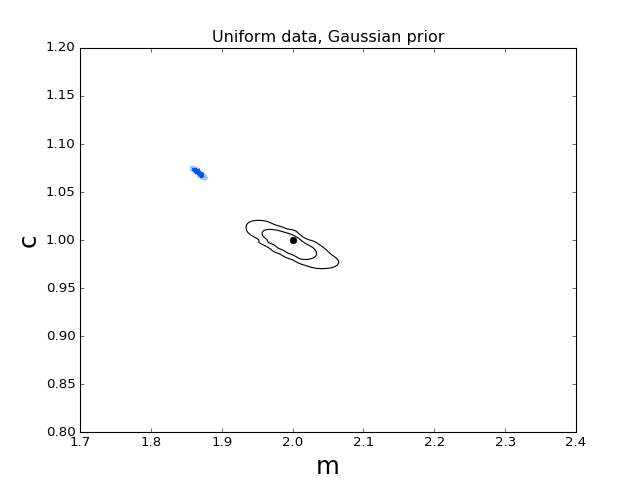

In [65]:
plt.figure()
smth = 2.5e3
contour_plot.contour(chain_std, [0,1], smooth=smth, labels=['m', 'c'])
contour_plot.contour(chain_zbeams_gauss, [0,1], smooth=smth*2.5, line=True, col='k')

plt.plot(m, c, 'ok')
plt.xlim([1.7, 2.4])
plt.ylim(0.8, 1.2)
plt.title('Uniform data, Gaussian prior')

<IPython.core.display.Javascript object>


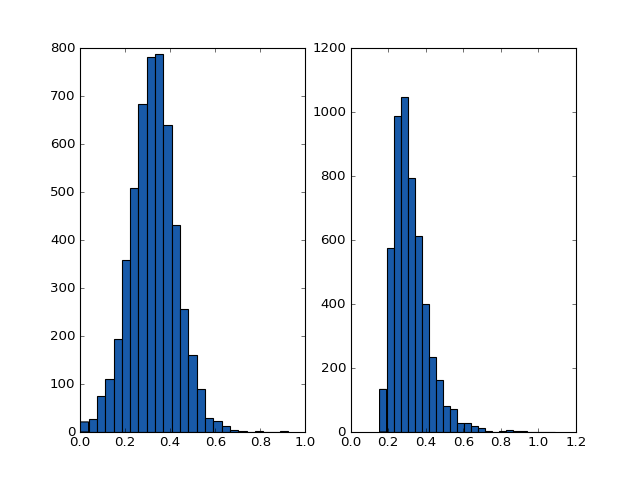

In [52]:
plt.figure()
plt.subplot(1,2,1)
plt.hist(chain_zbeams_gauss[:,2], 25, facecolor='#185aa9');
plt.subplot(1,2,2)
plt.hist(chain_zbeams_gauss[:,3], 25, facecolor='#185aa9');

## Data drawn from Gaussian prior, Gaussian prior in x

In [54]:
x_mu = 0.5
x_sig = 0.1

<IPython.core.display.Javascript object>


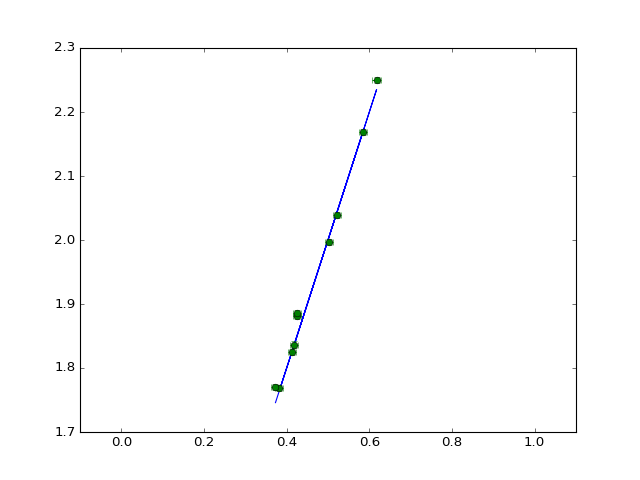

(-0.1, 1.1)

In [55]:
dat_gauss = make_data(10, m=m, c=c, x_mu=x_mu, x_sig=x_sig, y_err_actual=y_err, x_err_actual = x_err, y_err=y_err, x_err=x_err)
plt.figure()
plt.plot(dat_gauss[:,0], m*dat_gauss[:,0]+c)
plt.errorbar(dat_gauss[:,0], dat_gauss[:,1], linestyle='none', yerr=dat_gauss[:,2], xerr=dat_gauss[:,3], marker='o')

plt.xlim([-0.1, 1.1])

In [56]:
fd = FitData(dat_gauss, model='std')

fd.fit(chain_name='chain_std_gauss-')

Time taken 1.2269225120544434


In [57]:
fd = FitData(dat_gauss, model='zbeams', prior_choice='gaussian')

fd.fit(chain_name='chain_zbeams_gauss_gauss-')

Time taken 87.1754035949707


In [58]:
chain_std_gauss = np.loadtxt('chain_std_gauss-post_equal_weights.dat')
chain_zbeams_gauss_gauss = np.loadtxt('chain_zbeams_gauss_gauss-post_equal_weights.dat')

<IPython.core.display.Javascript object>


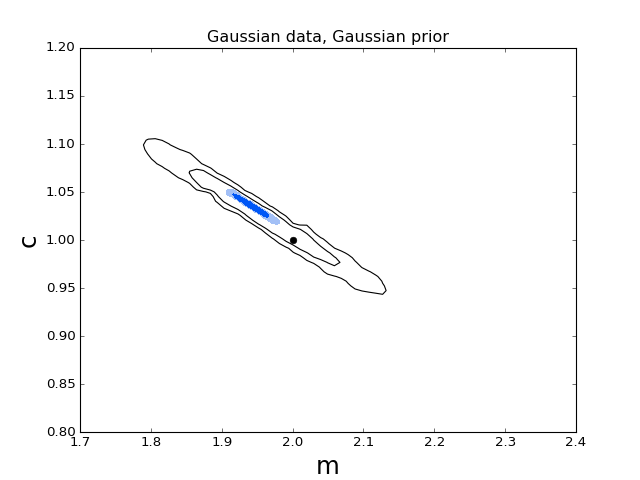

In [66]:
plt.figure()
smth = 2.5e3
contour_plot.contour(chain_std_gauss, [0,1], smooth=smth, labels=['m', 'c'])
contour_plot.contour(chain_zbeams_gauss_gauss, [0,1], smooth=smth*3, line=True, col='k')
plt.plot(m, c, 'ok')
plt.xlim([1.7, 2.4])
plt.ylim(0.8, 1.2)
plt.title('Gaussian data, Gaussian prior')

<IPython.core.display.Javascript object>


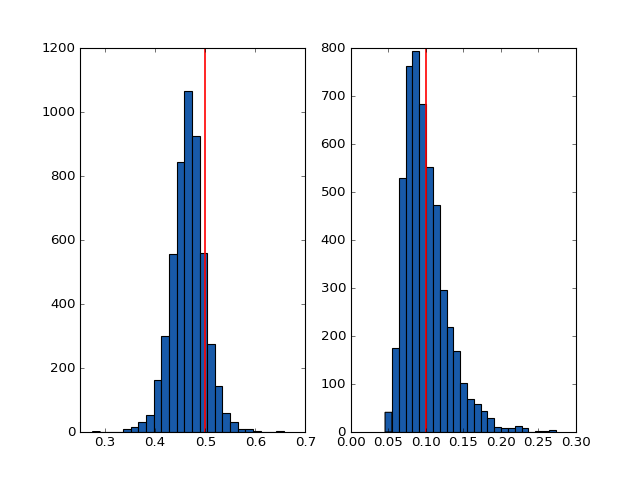

In [63]:
plt.figure()
plt.subplot(1,2,1)
plt.hist(chain_zbeams_gauss_gauss[:,2], 25, facecolor='#185aa9');
plt.plot([x_mu, x_mu], plt.gca().get_ylim(), 'r', lw=1.5)

plt.subplot(1,2,2)
plt.hist(chain_zbeams_gauss_gauss[:,3], 25, facecolor='#185aa9');
plt.plot([x_sig, x_sig], plt.gca().get_ylim(), 'r', lw=1.5)